## Objective: Determine which fungal and bacterial taxa are co-associated
Determine which plant and microbial taxa are co-associated  
Assumption: The same taxa will follow the same patterns across all samples (hence, use all samples)

In [4]:
# Loading required packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(plyr)
library(dplyr)
library(vegan)
library(ade4)
library(wesanderson)
library(igraph)
library(tidyr)
library(threejs)
library(htmlwidgets)

## First goal is merging the fungal and bacterial phyloseq objects

In [5]:
ps.f = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")
ps.f.norm = transform_sample_counts(ps.f, function(x) (x / sum(x)))
ps.f.norm = transform_sample_counts(ps.f, function(x) x+4)
# Adding 4 for different dataset offset - won't affect spearman ranking
ps.f.norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5938 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 5938 taxa by 16 taxonomic ranks ]

In [6]:
# Adding in the kingdom data.
#tt = data.frame(tax_table(ps.f.norm))
#tt$Kingdom = "Fungi"
#tt = as.matrix(tt)
#tax_table(ps.f.norm) = tax_table(tt)

In [583]:
ps.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
ps.m.norm = transform_sample_counts(ps.m, function(x) (x / sum(x)))
ps.m.norm = transform_sample_counts(ps.m, function(x) x+2)
# Adding 2 for different dataset offset - won't affect spearman ranking
ps.m.norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20020 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 20020 taxa by 7 taxonomic ranks ]

In [590]:
ps.m.shared = subset_samples(ps.m.norm,sample_names(ps.m.norm) %in% sample_names(ps.f.norm))
ps.f.shared = subset_samples(ps.f.norm,sample_names(ps.m.norm) %in% sample_names(ps.m.norm))

In [591]:
sum(row.names(as.matrix(otu_table(ps.m.shared))) == row.names(as.matrix(otu_table(ps.f.shared))))

[1] 101

In [592]:
ps.merged = merge_phyloseq(ps.f.shared,ps.m.shared)

In [593]:
# Need to make unique OTU names
taxa_names(ps.m.shared) = gsub("sq","Bsq",taxa_names(ps.m.shared))
taxa_names(ps.f.shared) = gsub("sq","Fsq",taxa_names(ps.f.shared))

In [594]:
otu_merged = otu_table(cbind(as.matrix(otu_table(ps.m.shared)),as.matrix(otu_table(ps.f.shared))),taxa_are_rows=FALSE)
tax_merged = tax_table(rbind(as.matrix(tax_table(ps.m.shared)),as.matrix(tax_table(ps.f.shared)[,1:7])))
samdat_merged = sample_data(ps.f.shared)

In [595]:
dim(otu_merged)
dim(tax_merged)
dim(samdat_merged)

[1]   101 25958

[1] 25958     7

[1] 101 103

In [596]:
ps.merged = phyloseq(otu_merged,tax_merged,samdat_merged)

In [597]:
ps.merged = prune_taxa(taxa_sums(ps.merged) > 0, ps.merged)
ps.merged
# Ok, got the merged phyloseq object with bacteria and fungi

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 25957 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 25957 taxa by 7 taxonomic ranks ]

## Also want one with the plants - merged O and M

In [599]:
# Merge the O and A for each site - they are being weighted evenly... not sure what's best
ps.f = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")
ps.f.norm = transform_sample_counts(ps.f, function(x) (x / sum(x)))
ps.f.merged = merge_samples(ps.f.norm, "Site_ID")
ps.f.merged = transform_sample_counts(ps.f.merged, function(x) (x / sum(x)))

ps.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
ps.m.norm = transform_sample_counts(ps.m, function(x) (x / sum(x)))
ps.m.merged = merge_samples(ps.m.norm, "Site_ID")
ps.m.merged = transform_sample_counts(ps.m.merged, function(x) (x / sum(x)))

In [600]:
# Import the plant data
ps.v = read.csv(file="../../data/Veg_data/Veg_Data_WBNPNWD_2015_forNetwork.csv",header=TRUE)
ps.v[is.na(ps.v)] = 0
row.names(ps.v)=ps.v[,1]
ps.v=ps.v[,2:dim(ps.v)[2]]
ps.v = otu_table(as.matrix(ps.v),taxa_are_rows=FALSE)

In [601]:
ps.v.norm = transform_sample_counts(ps.v, function(x) (x / sum(x)))

In [602]:
taxtab = data.frame(Kingdom=rep("Plantae",length(colnames(ps.v))), Phylum=rep("",length(colnames(ps.v))),Class=rep("",length(colnames(ps.v))),
                    Order=rep("",length(colnames(ps.v))),Family=rep("",length(colnames(ps.v))),Genus=colnames(ps.v),
                    Species=colnames(ps.v))
row.names(taxtab)=taxtab$Species

Genera = as.vector(taxtab$Genus)
Genera = t(data.frame(strsplit(Genera,"_")))[,1]
taxtab$Genus = Genera

Ericaceae = c('Arctostaphylos','Chamaedaphne','Chimaphila',"Kalmia","Pyrola","Vaccinium")

for (i in 1:dim(taxtab)[1]){
    m = taxtab[i,]$Genus
    x = ifelse(m %in% Ericaceae,"Ericaceae","")
    taxtab$NewFamily[i]=x
}
taxtab$Family=taxtab$NewFamily
taxtab=taxtab[,1:7]

taxtab=tax_table(taxtab)
colnames(taxtab)= c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
row.names(taxtab) = data.frame(taxtab)$Species
head(taxtab)

Warning message in .local(object):
“Coercing from data.frame class to character matrix 
prior to building taxonomyTable. 
This could introduce artifacts. 
Check your taxonomyTable, or coerce to matrix manually.”

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Achillea_millefolia,Plantae,,,,,Achillea,Achillea_millefolia
Acrocarpous_moss,Plantae,,,,,Acrocarpous,Acrocarpous_moss
Amelanchier_alnifolia,Plantae,,,,,Amelanchier,Amelanchier_alnifolia
Anemone_canadensis,Plantae,,,,,Anemone,Anemone_canadensis
Anemone_multifida,Plantae,,,,,Anemone,Anemone_multifida
Anemone_parviflora,Plantae,,,,,Anemone,Anemone_parviflora


In [603]:
# Get the sample data from the other ps objects and merge it into ps.v.norm
sd = sample_data(ps.m.merged)[sample_names(ps.m.merged)%in% sample_names(ps.v.norm)]
ps.v.norm = merge_phyloseq(sd,ps.v.norm,taxtab)
ps.v.norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 112 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 112 taxa by 7 taxonomic ranks ]

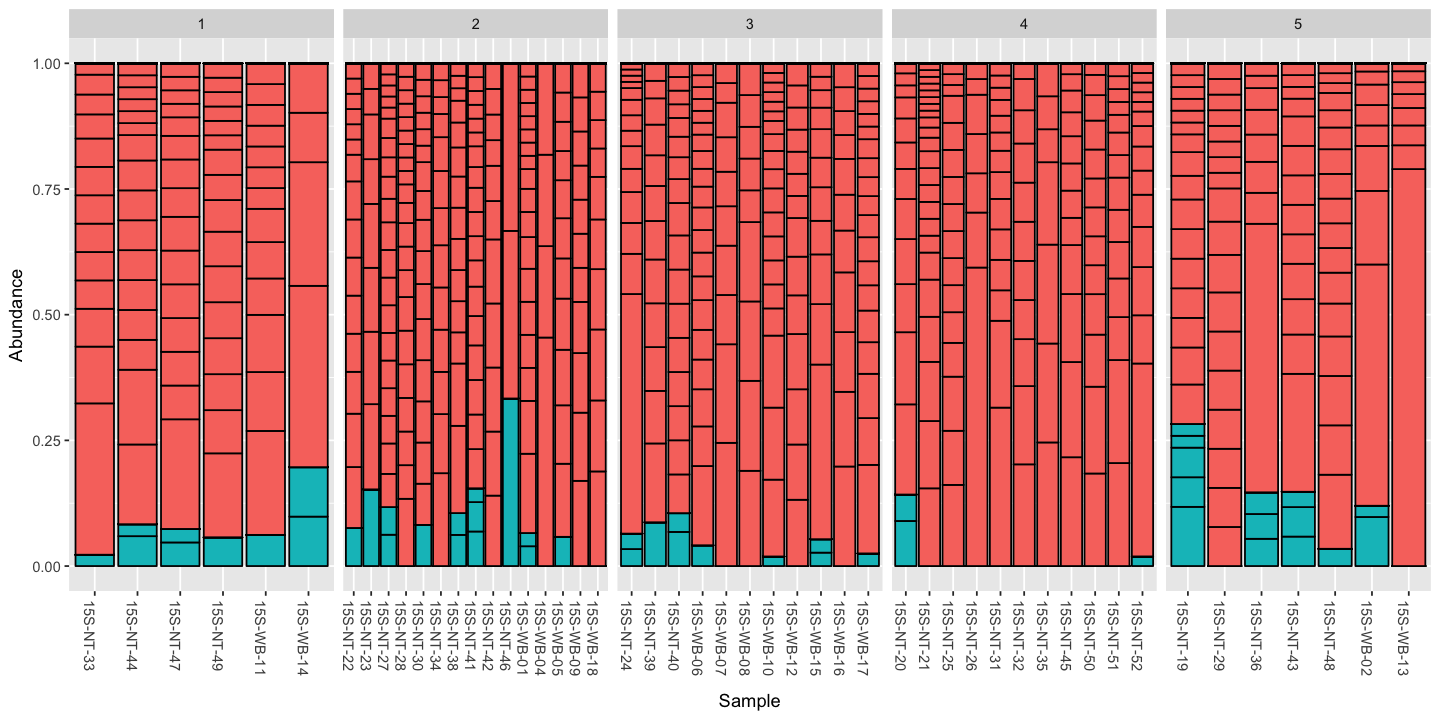

In [604]:
p = plot_bar(ps.v.norm,fill="Family")+guides(fill=FALSE)
p = p + facet_grid(~Veg_Comm, scales="free_x")
p
#ord=ordinate(ps.v.norm,method="PCoA",distance="bray")
#plot_ordination(ps.v.norm, ord, color="Surface_Severity_Class")

In [605]:
ERIC = psmelt(ps.v.norm)
colnames(ERIC)

[1] "OTU"                       "Sample"                   
  [3] "Abundance"                 "Barcodes"                 
  [5] "Sample_ID"                 "Site_ID"                  
  [7] "Org_or_Min"                "Exch_Na_mg_kg"            
  [9] "Exch_Mg_mg_kg"             "Exch_K_mg_kg"             
 [11] "Exch_Ca_mg_kg"             "pH"                       
 [13] "EC_mS_cm"                  "CEC_cmol_kg"              
 [15] "Total_N_pct"               "Total_S_pct"              
 [17] "Sand_pct"                  "Clay_pct"                 
 [19] "Silt_pct"                  "Ca_mg_kg"                 
 [21] "K_mg_kg"                   "Mg_mg_kg"                 
 [23] "Na_mg_kg"                  "P_mg_kg"                  
 [25] "S_mg_kg"                   "Al_mg_kg"                 
 [27] "Fe_mg_kg"                  "Zn_mg_kg"                 
 [29] "Cu_mg_kg"                  "Mn_mg_kg"                 
 [31] "Mo_mg_kg"                  "TIC_ash_pct"              
 [33] "TOC_LOI_pct"               "TOC_HCL_cruc_pct"         
 [35] "TC_pct"                    "Fire_ID"                  
 [37] "Ecosite"                   "Moisture"                 
 [39] "Moisture_Regime"           "Nutrient"                 
 [41] "Community"                 "Forest"                   
 [43] "Plains"                    "Interval"                 
 [45] "Veg_Comm"                  "Land_Class_Unburned"      
 [47] "Land_Class"                "Burned_Unburned"          
 [49] "Understory_CBI"            "Overstory_CBI"            
 [51] "CBI"                       "RBR"                      
 [53] "Pct_Exposed_Mineral"       "CFSI"                     
 [55] "Burn_Severity_Index"       "Mean_Duff_Depth_cm"       
 [57] "O_Depth_cm"                "Dead_Trees"               
 [59] "Live_Trees"                "nTrees"                   
 [61] "Severity_Class"            "temp"                     
 [63] "rh"                        "ws"                       
 [65] "prec"                      "ffmc"                     
 [67] "dmc"                       "dc"                       
 [69] "isi"                       "bui"                      
 [71] "fwi"                       "Correct_ID"               
 [73] "Number_Fires_Recorded"     "TSLF"                     
 [75] "TSO"                       "Fires_PerYear"            
 [77] "Fires_PerDecade_Recording" "Longest_Period_Btw_Fires" 
 [79] "Shortest_Period_Btw_Fires" "Mean_Period_Btw_Fires"    
 [81] "Reburn_Severity_Index"     "Overstory_Dens_ha"        
 [83] "Understory_Dens_ha"        "Abs_Density_Ha_UnderOver" 
 [85] "PINUBAN_Stems_Ha"          "PICEMAR_Stems_Ha"         
 [87] "PICEGLA_Stems_Ha"          "LARILAR_Stems_Ha"         
 [89] "POPUTRE_Stems_Ha"          "POPUBAL_Stems_Ha"         
 [91] "BETUPAP_Stems_Ha"          "PINUBAN_BA_per_Ha"        
 [93] "PICEMAR_BA_per_Ha"         "PICEGLA_BA_per_Ha"        
 [95] "LARILAR_BA_per_Ha"         "POPUTRE_BA_per_Ha"        
 [97] "POPUBAL_BA_per_Ha"         "BETUPAP_BA_per_Ha"        
 [99] "BA_ha"                     "Pct_Conifer_Stems_lar"    
[101] "Pct_Conifer_BA_lar"        "Median_CBH"               
[103] "Flammable_T_ha"            "Conifer_CBD"              
[105] "Surface_Severity_Class"    "Soil_Class"               
[107] "Kingdom"                   "Phylum"                   
[109] "Class"                     "Order"                    
[111] "Family"                    "Genus"                    
[113] "Species"

In [606]:
levels(sample_data(ps.f.norm)$Veg_Comm)

[1] "Black Spruce"  "Jack Pine"     "Mixedwood"     "Open Wetland" 
[5] "Treed Wetland"

In [607]:
ERIC = psmelt(ps.v.norm) %>%
    group_by(Sample,OTU,Genus,Species, Family,Burned_Unburned,RBR,Severity_Class,Land_Class,Veg_Comm)%>%
    summarize(Abundance=sum(Abundance))%>%
    filter(Family=="Ericaceae")%>%
    group_by(Severity_Class,Veg_Comm,Genus,Species,OTU)%>%
    summarize(Abundance=mean(Abundance))
ERIC$Veg_Comm = as.factor(ERIC$Veg_Comm)
ERIC$Severity_Class = as.factor(ERIC$Severity_Class)
ERIC$Veg_Comm = mapvalues(ERIC$Veg_Comm, from = levels(ERIC$Veg_Comm), 
                                to = c('Black Spruce','Jack Pine','Mixedwood','Open Wetland','Treed Wetland'))
ERIC$Severity_Class = mapvalues(ERIC$Severity_Class, from = levels(ERIC$Severity_Class), 
                                to = c('Low',"Moderate","High"))

head(ERIC)

Severity_Class,Veg_Comm,Genus,Species,OTU,Abundance
Low,Black Spruce,Arctostaphylos,Arctostaphylos_rubra,Arctostaphylos_rubra,0
Low,Black Spruce,Arctostaphylos,Arctostaphylos_uva.ursi,Arctostaphylos_uva.ursi,0
Low,Black Spruce,Chamaedaphne,Chamaedaphne_calyculata,Chamaedaphne_calyculata,0
Low,Black Spruce,Chimaphila,Chimaphila_umbellata,Chimaphila_umbellata,0
Low,Black Spruce,Kalmia,Kalmia_polifolia,Kalmia_polifolia,0
Low,Black Spruce,Pyrola,Pyrola_asarifolia,Pyrola_asarifolia,0


In [608]:
ERIC$Severity_Class=as.factor(ERIC$Severity_Class)
ERIC$Veg_Comm=as.factor(ERIC$Veg_Comm)
#ERIC = ERIC %>%
#    filter(OTU %in% c('Vaccinium_vitis.idaea','Arctostaphylos_uva.ursi'))

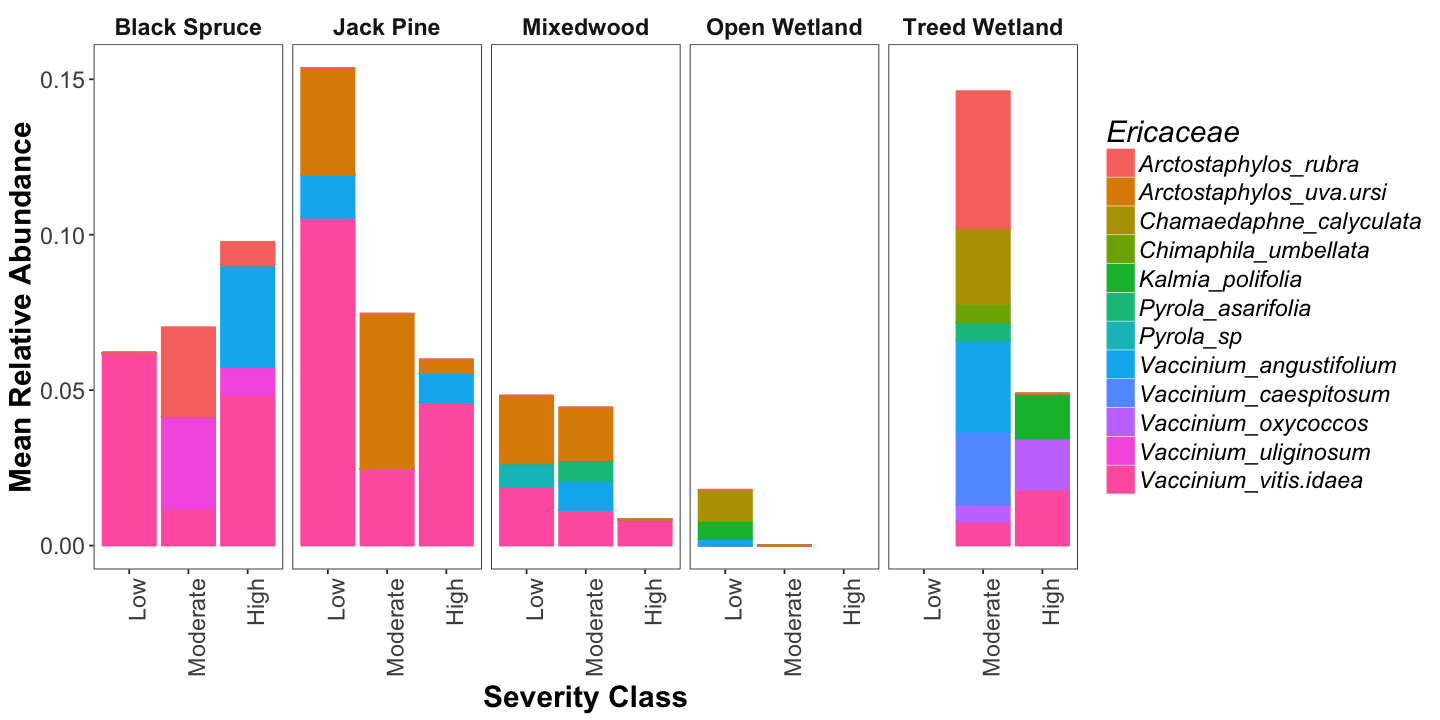

In [609]:
options(repr.plot.width=12, repr.plot.height=6)
p = ggplot(ERIC,aes(x=Severity_Class,y=Abundance,color=OTU,fill=OTU))
p = p + geom_bar(stat="identity") + facet_grid(~Veg_Comm)
p = p + guides(color=guide_legend(title="Ericaceae"),fill=guide_legend(title="Ericaceae"))
p = p + ylab("Mean Relative Abundance") + xlab("Severity Class")
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=18, face="bold"),
        axis.text = element_text(size=14),
      axis.text.x = element_text(angle=90,hjust=1),
        legend.text = element_text(size=14,face="italic"),
        legend.title = element_text(size = 18,face="italic"),
        strip.background = element_rect(colour="white", fill="white"))
p

In [611]:
# Making the M-F common samples
ps.m.merged = subset_samples(ps.m.merged,sample_names(ps.m.merged) %in% sample_names(ps.f.merged))
ps.m.merged = subset_samples(ps.m.merged,sample_names(ps.m.merged) %in% sample_names(ps.v.norm))
ps.f.merged = subset_samples(ps.f.merged,sample_names(ps.f.merged) %in% sample_names(ps.m.merged))
ps.f.merged = subset_samples(ps.f.merged,sample_names(ps.f.merged) %in% sample_names(ps.v.norm))
                                      
# Need to make unique OTU names
taxa_names(ps.m.merged) = gsub("sq","Bsq",taxa_names(ps.m.merged))
taxa_names(ps.f.merged) = gsub("sq","Fsq",taxa_names(ps.f.merged))

# Merging OTU tables and tax tables and sample data
otu_merged = otu_table(cbind(as.matrix(otu_table(ps.m.merged)),as.matrix(otu_table(ps.f.merged)),as.matrix(otu_table(ps.v.norm))),taxa_are_rows=FALSE)
tax_merged = tax_table(rbind(as.matrix(tax_table(ps.m.merged)),as.matrix(tax_table(ps.f.merged)[,1:7]),as.matrix(tax_table(ps.v.norm))))
samdat_merged = sample_data(ps.f.merged)

# Making merged M-F ps object
ps.merged.v = phyloseq(otu_merged,tax_merged,samdat_merged)

In [612]:
ps.merged.v

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 26070 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 26070 taxa by 7 taxonomic ranks ]

### Simply looking at Ericoid mycorrhizae and Ericaceae

In [24]:
Ericaceae = c('Arctostaphylos','Chamaedaphne','Chimaphila',"Kalmia","Pyrola","Vaccinium")
# Getting the plant genera that are ericaceous
ER = levels(as.factor(data.frame(tax_table(ps.f.norm))$Guild))[grep("Ericoid",levels(as.factor(data.frame(tax_table(ps.f.norm))$Guild)))]
# Getting the guilds that contain putative ericoid mycorrhizae

In [25]:
ps.f.norm.ER = merge_samples(ps.f.norm, "Site_ID")
ps.f.norm.ER = transform_sample_counts(ps.f.norm.ER, function(x) (x / sum(x)))

ps.v.norm.ER = subset_taxa(ps.v.norm,Genus %in% Ericaceae)
ps.f.norm.ER = subset_taxa(ps.f.norm.ER,Guild %in% ER)
# Subsetting the phyloseq object to contain only those
ps.f.norm.ER
ps.v.norm.ER
# Checking it out

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 116 taxa and 62 samples ]
sample_data() Sample Data:       [ 62 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 116 taxa by 16 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 102 sample variables ]
tax_table()   Taxonomy Table:    [ 12 taxa by 7 taxonomic ranks ]

In [26]:
# Making the M-F common samples
ps.f.norm.ER = subset_samples(ps.f.norm.ER,sample_names(ps.f.norm.ER) %in% sample_names(ps.v.norm.ER))
ps.v.norm.ER = subset_samples(ps.v.norm.ER,sample_names(ps.v.norm.ER) %in% sample_names(ps.f.norm.ER))
                                      
# Need to make unique OTU names
taxa_names(ps.f.norm.ER) = gsub("sq","Fsq",taxa_names(ps.f.norm.ER))

# Merging OTU tables and tax tables and sample data
otu_merged.ER = otu_table(cbind(as.matrix(otu_table(ps.f.norm.ER)),as.matrix(otu_table(ps.v.norm.ER))),taxa_are_rows=FALSE)
tax_merged.ER = tax_table(rbind(as.matrix(tax_table(ps.v.norm.ER)),as.matrix(tax_table(ps.f.norm.ER)[,1:7])))
samdat_merged.ER = sample_data(ps.f.norm.ER)

# Making merged M-F ps object
ps.merged.ER = phyloseq(otu_merged.ER,tax_merged.ER,samdat_merged.ER)
ps.merged.ER

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 128 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 128 taxa by 7 taxonomic ranks ]

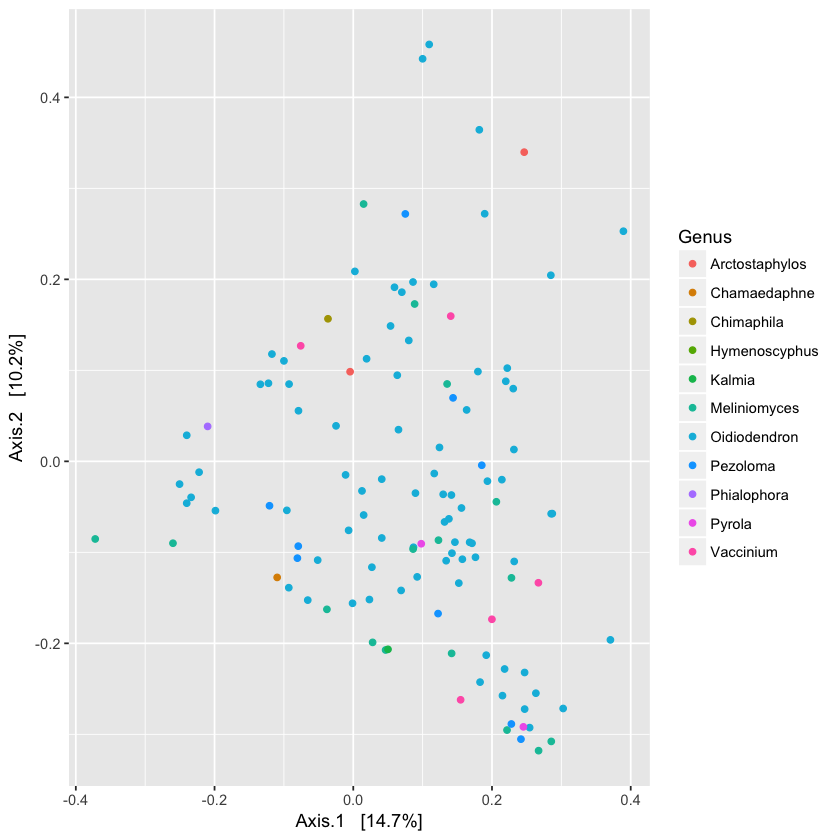

In [27]:
ord=ordinate(ps.merged.ER,method="PCoA",distance="bray")
plot_ordination(ps.merged.ER, ord, color="Genus",type="taxa")

### Want to follow Connor et al. Using null models to infer microbial co-occurrence networks
Their dataset excluded OTUs with fewer than 5 observances across sites. Could use this approach. Dada2 already somewhat corrects for any singleton issues, so proceeding for now without doing this.  
First, they add noise to their abundance data to deal with sparsity (many many 0's in the OTU table):

In [28]:
# Figuring out what the smallest distance between any two non-zero taxa is.

In [30]:
cutoff = 0.00003
#ps.mini = prune_taxa(taxa_sums(ps.merged.v) < cutoff, ps.merged.v)
ps.mini = prune_taxa(taxa_sums(ps.v.norm) < cutoff, ps.v.norm)
ps.mini

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 102 sample variables ]
tax_table()   Taxonomy Table:    [ 1 taxa by 7 taxonomic ranks ]

In [31]:
# Kernel dies if we do it with full dataset.
# Start with mini
Vals = outer(otu_table(ps.v.norm),otu_table(ps.v.norm),"-")
delta = min(Vals[Vals>0])
delta

[1] 8.062329e-12

For common taxa (cutoff >0.2, 148 OTUs), delta was 8.69739860399855e-10  
For rare taxa (cutoff < 0.00003, 224 OTUs), delta was 2.44078202072462e-08  
For veg comm only, delta was 8e-12  
Let's use 1e-14

In [614]:
delta = 1e-14

In [615]:
# For developing method, proceeding with much-reduced data
cutoff = 0.005
#ps.mini = subset_taxa(ps.merged.ER, Kingdom=="Plantae"|Phylum=="Ascomycota"|Phylum=="Basidiomycota")
ps.mini = prune_taxa((taxa_sums(ps.merged.v) > cutoff & taxa_sums(ps.merged.v) < 1 )| (taxa_sums(ps.merged.v) > (cutoff+2) & taxa_sums(ps.merged.v) < (1+2) ) | (taxa_sums(ps.merged.v) > (cutoff+4) & taxa_sums(ps.merged.v) < (1+4) ), ps.merged.v)
#ps.mini = prune_taxa(taxa_sums(ps.merged.v) > cutoff, ps.merged.v)
ps.mini
# Needs less than ~8500 taxa for matrix stuff to work

# Maybe want just present in X samples
ps.mini1 = filter_taxa(ps.merged.v, abundance > 0, persistence = 10)
ps.mini2 = genefilter_sample(ps.merged.v, filterfun_sample(function(x) x > 0), A = 0.1*nsamples(ps.merged.v))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2164 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 2164 taxa by 7 taxonomic ranks ]

ERROR: Error in filter_taxa(ps.merged.v, abundance > 0, persistence = 10): unused argument (persistence = 10)


In [616]:
b = delta/1000
E = replicate(dim(otu_table(ps.mini))[1], rnorm(dim(otu_table(ps.mini))[2]))
E = 2*b*E
E = -b + E
dim(E)
# Gives us a tiny matrix of very small numbers, 
# smaller than the smallest difference between our OTU counts
# This will be used to add random noise to our OTU table.

[1] 2164   50

In [617]:
otu_table(ps.mini) = otu_table(as.matrix(otu_table(ps.mini))+abs(t(E)),taxa_are_rows=FALSE)
# In theory, we then need to do this noise step 2000 times. For now, once.

In [618]:
head(otu_table(ps.mini))
# Now the zeros are now very small numbers.
# This will help avoid spurious correlations between OTUs
# However, it will still be important to choose a cutoff prudently.
# Perhaps the network shapes will fall off dramatically here, too, though.

# "[...] in practice, choosing an intermediate value for the threshold is a reasonable strategy. 
# The threshold should be large enough to be above the noise transition (Fig 2, green line), 
# but small enough that the network is not mostly disconnected."

# Must perform robustness analysis to demonstrate parameters of interest
# are not affected by choice of threshold.

,Bsq3,Bsq4,Bsq5,Bsq6,Bsq7,Bsq8,Bsq9,Bsq10,Bsq11,Bsq12,⋯,Unknown_B,Unknown_C,Vaccinium_angustifolium,Vaccinium_caespitosum,Vaccinium_oxycoccos,Vaccinium_uliginosum,Viburnum_edule,Vicia_americana,Viola_sp,Zigadenus_elegans
15S-NT-19,1.309325e-02,0.005611392,2.743347e-04,0.029802728,9.950869e-03,6.633913e-03,2.868045e-04,1.847290e-17,1.986433e-02,5.112602e-04,⋯,5.443366e-18,2.953640e-17,5.888126e-02,5.888126e-02,4.727410e-18,1.018553e-17,2.119481e-17,2.916715e-17,6.839022e-18,2.075604e-17
15S-NT-20,2.459477e-18,0.187301631,4.375860e-17,0.001062567,1.263740e-17,4.553860e-04,1.235042e-17,3.203485e-17,1.885392e-17,1.379957e-03,⋯,3.096442e-17,3.745640e-17,7.959036e-18,3.572502e-17,1.200190e-17,1.983797e-17,1.032441e-17,4.338429e-18,5.536727e-18,7.426273e-18
15S-NT-21,6.060020e-03,0.001258718,5.335529e-18,0.030305819,6.269542e-03,1.640487e-17,7.256407e-18,6.769171e-04,8.783806e-03,2.005573e-17,⋯,1.867976e-17,2.117568e-17,1.040857e-18,3.157469e-18,3.802347e-17,2.536061e-18,4.165333e-18,4.733367e-18,1.061990e-17,3.766891e-17
15S-NT-22,3.388523e-18,0.067390492,1.035091e-02,0.016115708,1.960065e-17,3.972065e-03,1.960357e-02,7.358276e-19,1.159052e-17,1.526520e-03,⋯,1.922457e-17,3.013533e-17,2.214275e-17,1.802923e-17,5.115294e-17,4.732525e-18,1.222153e-17,4.950557e-17,1.950379e-17,3.015387e-20
15S-NT-23,2.060709e-02,0.002845347,2.008847e-02,0.004946212,5.601021e-03,3.882510e-02,1.047902e-02,6.264225e-18,4.465258e-03,7.831934e-18,⋯,1.968615e-18,5.333616e-18,7.212941e-18,1.144416e-17,2.791460e-17,1.111328e-17,3.079276e-18,2.253172e-17,1.947179e-17,3.417007e-17
15S-NT-24,2.621020e-02,0.036449437,1.931184e-03,0.018466422,3.660771e-02,2.297493e-03,1.298418e-02,5.669635e-18,2.380090e-03,9.271336e-03,⋯,1.724003e-17,2.561960e-17,9.007402e-18,5.088947e-18,2.618272e-17,1.464719e-17,2.442764e-18,1.735437e-17,2.378774e-17,4.841094e-17


In [619]:
ps.dist.mini = cor(otu_table(ps.mini), use="everything", method="spearman") 

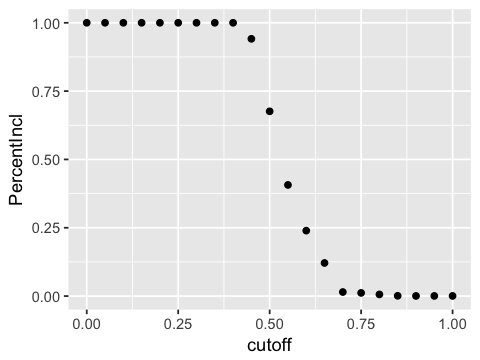

In [620]:
# Creating a cutoff function to collect the cutoff and the fraction of OTUs that are included
cutoff_function = function(cutoff){
    adjacency_matrix = as.matrix(ps.dist.mini)
    adjacency_matrix[abs(adjacency_matrix)<cutoff] = 0
    adjacency_matrix[abs(adjacency_matrix)>cutoff] = 1
    am = graph.adjacency(adjacency_matrix)
    c = clusters(am)
    MaxSize = c$csize[1]
    return(c(cutoff,MaxSize/dim(adjacency_matrix)[1]))
    }

# Test it against all these valuse
inputs=seq(0,1,0.05)

# Apply the function to the range of values and turn it into a dataframe
df = t(sapply(inputs,cutoff_function))
colnames(df) = c("cutoff","PercentIncl")
df=data.frame(df)

# Plot it
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df,aes(x=cutoff,y=PercentIncl))
p = p + geom_point()
p

###  https://www.jessesadler.com/post/network-analysis-with-r/

In [34]:
cutoff = 0.75

adjacency_matrix = as.matrix(ps.dist.mini)
#adjacency_matrix = adjacency_matrix[adjacency_matrix>0]
adjacency_matrix[abs(adjacency_matrix)<cutoff] = 0
adjacency_matrix[abs(adjacency_matrix)>cutoff] = 1
adjacency_matrix = adjacency_matrix[rowSums(adjacency_matrix)>0,]
am = graph.adjacency(adjacency_matrix, diag=FALSE, mode=c("undirected"), weighted=TRUE)
edge_list = get.edgelist(am)
colnames(edge_list)=c("A","B")
edge_list=data.frame(edge_list)
edge_list$CorVal=""
edge_list$CorSign=""

In [35]:
# Want to add correlation values
for (i in 1:dim(edge_list)[1]){
    CorVal = ps.dist.mini[which(rownames(ps.dist.mini)==data.frame(edge_list)$A[i]),
                 which(colnames(ps.dist.mini)==data.frame(edge_list)$B[i])]
    CorSign = ifelse(CorVal>0,"Positive","Negative")
    edge_list[i,3]=CorVal
    edge_list[i,4]=CorSign
    }
edge_list$EdgeColor[edge_list$CorSign=="Positive"] = "navy"
edge_list$EdgeColor[edge_list$CorSign=="Negative"] = "red"
head(edge_list)

A,B,CorVal,CorSign,EdgeColor
Bsq1,Bsq13,0.756158463385354,Positive,navy
Bsq1,Bsq78,0.798799519807923,Positive,navy
Bsq1,Bsq86,0.76797118847539,Positive,navy
Bsq2,Bsq5,0.761920768307323,Positive,navy
Bsq2,Bsq8,0.779783913565426,Positive,navy
Bsq2,Bsq12,0.814453781512605,Positive,navy


In [36]:
# Get the taxon info for vertices
node_list = data.frame(row.names(as.matrix(ps.dist.mini)),tax_table(ps.mini))
# Add the OTU ID column
colnames(node_list)[1] = "OTU"
# Get rid of anything not kept in the adjacency matrix
nodes.remaining = levels(droplevels(data.frame(edge_list)$A))
node_list = node_list[row.names(node_list) %in% nodes.remaining,]

# Check out how long it is
head(node_list)

,OTU,Kingdom,Phylum,Class,Order,Family,Genus,Species
Bsq1,Bsq1,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,,NA
Bsq2,Bsq2,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,,NA
Bsq3,Bsq3,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia,NA
Bsq5,Bsq5,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,NA
Bsq7,Bsq7,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,,NA
Bsq8,Bsq8,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Burkholderia-Paraburkholderia,NA


In [37]:
# Add fire-responsive data to the node list
l2FC.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fc.df")
l2FC.f =readRDS("CHTC/Dada2_Results_OA20_PEAR_Full/l2fcFull.df")

m = l2FC.m%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC>1)%>%
    arrange(OTU)
m$OTU = gsub("sq","Bsq",m$OTU)
m.fire = levels(as.factor(m$OTU))
head(m.fire)
f = l2FC.f%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC>1)%>%
    arrange(OTU)
f$OTU = gsub("sq","Fsq",f$OTU)
f.fire = levels(as.factor(f$OTU))
head(f.fire)

node_list$FireResponseColor = ""
node_list$FireResponseShape = ""
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    FireResponseColor = ifelse((OTU %in% f.fire | OTU %in% m.fire),"red","white")
    FireResponseShape = ifelse((OTU %in% f.fire | OTU %in% m.fire),"square","circle")
    node_list$FireResponseColor[i] = FireResponseColor
    node_list$FireResponseShape[i] = FireResponseShape
}

node_list$MeanAbund = c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    MeanAbund = ifelse(OTU %in% m$OTU,m$MeanAbund[m$OTU==OTU],ifelse(OTU %in% f$OTU,f$MeanAbund[f$OTU==OTU],0.0001))
    node_list$MeanAbund[i] = MeanAbund
}
head(node_list)

[1] "Bsq1"   "Bsq102" "Bsq105" "Bsq107" "Bsq108" "Bsq109"

[1] "Fsq10"   "Fsq105"  "Fsq1068" "Fsq108"  "Fsq11"   "Fsq113"

,OTU,Kingdom,Phylum,Class,Order,Family,Genus,Species,FireResponseColor,FireResponseShape,MeanAbund
Bsq1,Bsq1,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,,NA,red,square,0.030794281
Bsq2,Bsq2,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,,NA,white,circle,0.000100000
Bsq3,Bsq3,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia,NA,red,square,0.015485507
Bsq5,Bsq5,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,NA,red,square,0.011347059
Bsq7,Bsq7,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,,NA,red,square,0.009418947
Bsq8,Bsq8,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Burkholderia-Paraburkholderia,NA,red,square,0.006349000


In [38]:
node_list$VertexSize = ifelse((as.numeric(node_list$MeanAbund)*500)>1,as.numeric(node_list$MeanAbund)*500,3)
node_list$VertexLabel = ifelse(!is.na(node_list$Genus) & node_list$Genus!="",paste(node_list$Genus),
                              ifelse(!is.na(node_list$Family) & node_list$Family!="",paste(node_list$Family),
                                    ifelse(!is.na(node_list$Order) & node_list$Order!="",paste(node_list$Order),
                                            ifelse(!is.na(node_list$Class) & node_list$Class!="",paste(node_list$Class),
                                                   ifelse(!is.na(node_list$Phylum) & node_list$Phylum!="",paste(node_list$Phylum),NA)))))

In [39]:
igraph = graph_from_data_frame(edge_list,directed=FALSE)

In [40]:
V(igraph)$size=node_list$VertexSize
V(igraph)$color=node_list$FireResponseColor
V(igraph)$label=node_list$VertexLabel

Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”

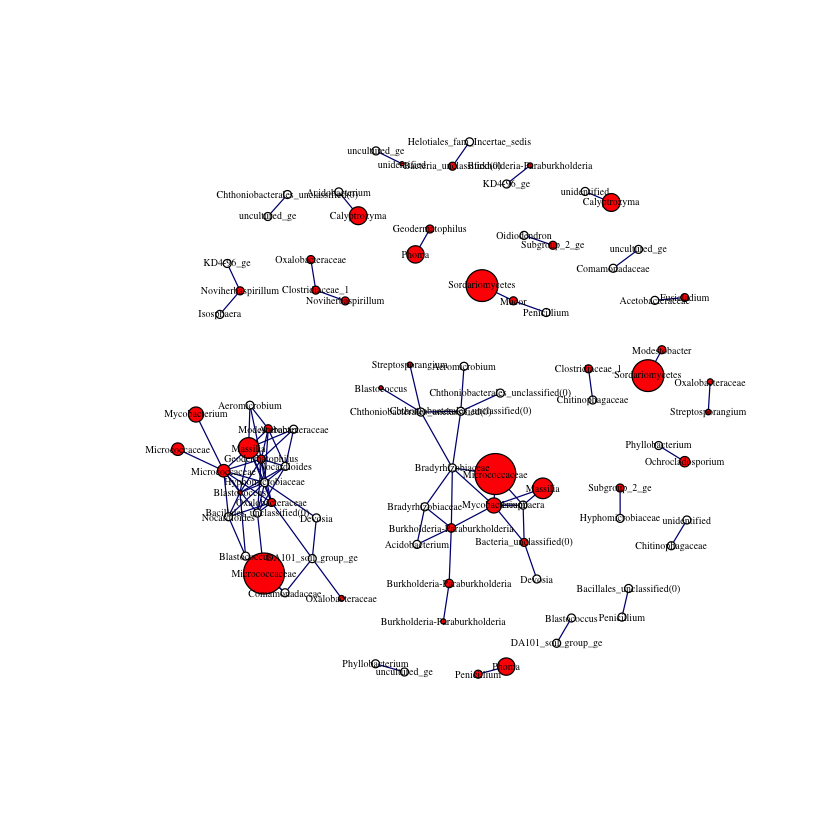

In [41]:
options(repr.plot.width=7, repr.plot.height=7)

#coul = wes_palette("Darjeeling")[1:length(levels(droplevels(node_list$Kingdom)))]
#my_color=coul[as.numeric(as.factor(droplevels(node_list$Kingdom)))]
plot.igraph(igraph,
            #vertex.size=3,
            #vertex.size=node_list$VertexSize,
            #vertex.shape=node_list$FireResponseShape,
            #vertex.color=node_list$FireResponseColor,
            #vertex.label=node_list$Family,
            #vertex.label=NA,
            vertex.label.cex=c(0.5),
            vertex.label.color=c("black"),
            #vertex.label.dist=c(0.75),
            edge.color=edge_list$EdgeColor,
            #edge.label=edge_list$CorVal,
            )
# Would be cool to colour by fire response - see if one group is high fire, other low?

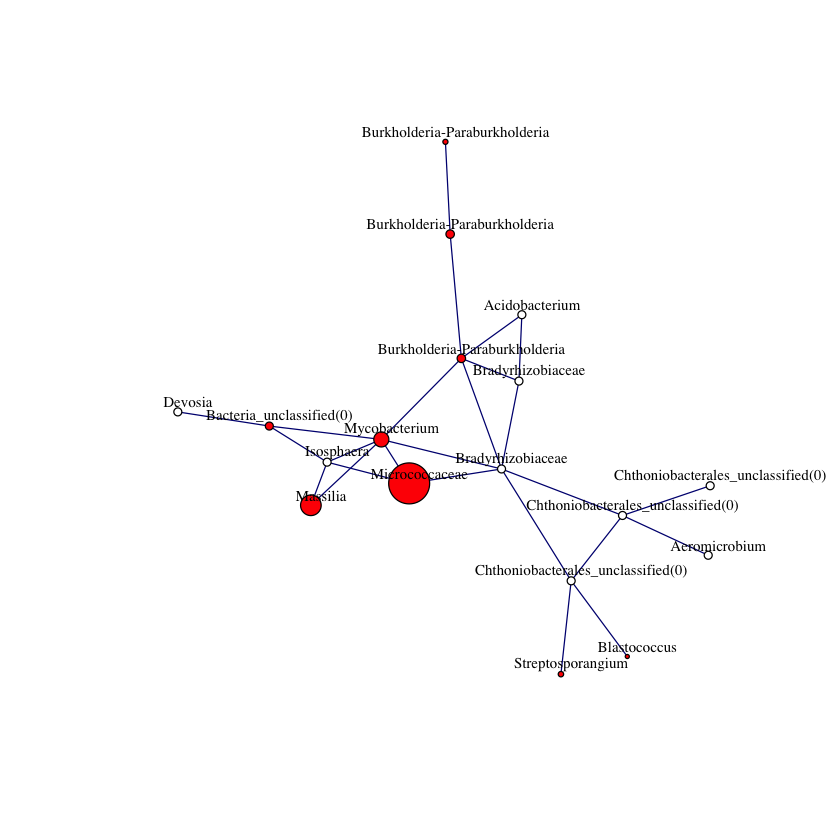

In [43]:
igraph.sm=decompose.graph(igraph)[[2]]

# Get rid of anything not kept in the adjacency matrix
nodes.remaining = V(igraph.sm)$name
node_list.sm = node_list[row.names(node_list) %in% nodes.remaining,]

plot.igraph(igraph.sm, 
            #vertex.size=node_list.sm$VertexSize, 
            #vertex.color=node_list.sm$FireResponseColor,
            #vertex.label=node_list.sm$Genus,
            #vertex.label=NA,
            vertex.label.cex=c(0.75),
            vertex.label.color=c("black"),
            vertex.label.dist=c(0.75),
            edge.color=edge_list$EdgeColor,
            edge.width=1
           #edge.label=edge_list$CorVal,
           )

## Pseudocode of what we want to do for Connor et al.

First, we add the random noise to the matrix.  
    Do this 2000 times, to generate 2000 matrices. (I think, ultimately, all 2000 matrices are used to determine which edges are present in 90% of the matrices.)
Then, from each of these matrices, we want to create a "uniformly random permutation of the entries in the OTU abundance matrix while maintaining the background distribution of abundances from which the values were sampled". I am interpreting this as take the values from the matrix, and then randomly sample from it (with replacement) to create a new matrix.  
For this new matrix, we then compute Spearman's rho, and make the plot of fraction of OTUs in the biggest module within the matrix, as the cutoff increases. It's actually not totally clear whether this was done for each matrix or just once - Figure 2 has just the one line.  
Let's start with this.

In [621]:
cutoff = 0.005
# Sum of least abundant taxa
ps.mini = prune_taxa((taxa_sums(ps.merged.v) > cutoff & taxa_sums(ps.merged.v) < 1 )| (taxa_sums(ps.merged.v) > (cutoff+2) & taxa_sums(ps.merged.v) < (1+2) ) | (taxa_sums(ps.merged.v) > (cutoff+4) & taxa_sums(ps.merged.v) < (1+4) ), ps.merged.v)
#ps.mini = prune_taxa(taxa_sums(ps.merged.v) > cutoff, ps.merged.v)
ps.mini

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2164 taxa and 50 samples ]
sample_data() Sample Data:       [ 50 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 2164 taxa by 7 taxonomic ranks ]

In [622]:
#### Matrix with no noise added ####

# Setting up the data frame
Rep=c()
cutoff=c()
PercentIncl=c()
df.no=data.frame(Rep,cutoff,PercentIncl)


#Running it multiple times
for (i in 1:1){

# Record iteration
Rep = i

# Setting code to run first on smaller dataset
cutoff = 0.005
# Sum of least abundant taxa - leaves ~2180 taxa

ps.mini = prune_taxa(taxa_sums(ps.merged.v) > cutoff, ps.merged.v)

ps.dist.mini = cor(otu_table(ps.mini), use="everything", method="spearman") 
# Calculate spearman correlations

# Creating a cutoff function to collect the Spearman rho cutoff and the fraction of OTUs that are included
# in largest cluster
cutoff_function = function(cutoff){
    adjacency_matrix = as.matrix(ps.dist.mini)
    adjacency_matrix[abs(adjacency_matrix)<cutoff] = 0
    adjacency_matrix[abs(adjacency_matrix)>cutoff] = 1
    am = graph.adjacency(adjacency_matrix)
    c = clusters(am)
    MaxSize = c$csize[1]
    return(c(cutoff,MaxSize/dim(adjacency_matrix)[1]))
    }

# Test it against this range of values
inputs=seq(0.25,0.85,0.05)

# Apply the function to the range of values and turn it into a dataframe
df = t(sapply(inputs,cutoff_function))
df=data.frame(df)
df = data.frame(i,df)
colnames(df) = colnames(df.no)
df.no=rbind(df.no,df)
}
colnames(df.no) = c("Rep","Cutoff","PctIncl")

In [623]:
#### Matrix with just noise added ####

# Setting up the data frame
Rep=c()
cutoff=c()
PercentIncl=c()
df.list=data.frame(Rep,cutoff,PercentIncl)


#Starting out running it 100 times
for (i in 1:100){

# Record iteration
Rep = i

# Setting code to run first on smaller dataset
cutoff = 0.005
# Sum of least abundant taxa - leaves ~2180 taxa

delta = 1e-14
# Smaller than smallest difference between taxa

ps.mini = prune_taxa(taxa_sums(ps.merged.v) > cutoff, ps.merged.v)

# Making matrix of random values
b = delta/1000
E = replicate(dim(otu_table(ps.mini))[1], rnorm(dim(otu_table(ps.mini))[2]))
E = 2*b*E
E = -b + E

otu_table(ps.mini) = otu_table(as.matrix(otu_table(ps.mini))+abs(t(E)),taxa_are_rows=FALSE)
# Add the noise to the matrix

ps.dist.mini = cor(otu_table(ps.mini), use="everything", method="spearman") 
# Calculate spearman correlations

# Creating a cutoff function to collect the Spearman rho cutoff and the fraction of OTUs that are included
# in largest cluster
cutoff_function = function(cutoff){
    adjacency_matrix = as.matrix(ps.dist.mini)
    adjacency_matrix[abs(adjacency_matrix)<cutoff] = 0
    adjacency_matrix[abs(adjacency_matrix)>cutoff] = 1
    am = graph.adjacency(adjacency_matrix)
    c = clusters(am)
    MaxSize = c$csize[1]
    return(c(cutoff,MaxSize/dim(adjacency_matrix)[1]))
    }

# Test it against this range of values
inputs=seq(0.25,0.85,0.05)

# Apply the function to the range of values and turn it into a dataframe
df = t(sapply(inputs,cutoff_function))
df=data.frame(df)
df = data.frame(i,df)
colnames(df) = colnames(df.list)
df.list=rbind(df.list,df)
}
colnames(df.list) = c("Rep","Cutoff","PctIncl")

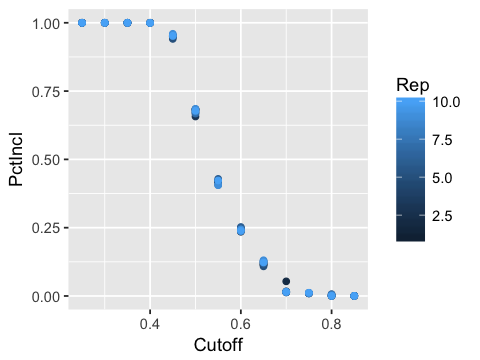

In [624]:
# Plot it
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df.list,aes(x=Cutoff,y=PctIncl, color=Rep))
p = p + geom_point()
p

In [625]:
#### Matrix with noise and permuations added ####

# Setting up the data frame
Rep=c()
cutoff=c()
PercentIncl=c()
df.list.permute=data.frame(Rep,cutoff,PercentIncl)


#Starting out running it 100 times
for (i in 1:100){

# Record iteration
Rep = i
  
# Setting code to run first on smaller dataset
cutoff = 0.005
# Sum of least abundant taxa

delta = 1e-14
# Smaller than smallest difference between taxa

ps.mini = prune_taxa(taxa_sums(ps.merged.v) > cutoff, ps.merged.v)

# Making matrix of random values
b = delta/1000
E = replicate(dim(otu_table(ps.mini))[1], rnorm(dim(otu_table(ps.mini))[2]))
E = 2*b*E
E = -b + E

otu_table(ps.mini) = otu_table(as.matrix(otu_table(ps.mini))+abs(t(E)),taxa_are_rows=FALSE)
# Add the noise to the matrix

M = matrix(otu_table(ps.mini))
# Get the OTU table as matrix

n = dim(M)[1]*dim(M)[2]
# number of elements in matrix

M.new = matrix(base::sample(M, n, replace=TRUE),nrow=dim(otu_table(ps.mini))[1])
# Sample the matrix with replacement; make new random matrix

ps.dist.mini = cor(M.new, use="everything", method="spearman") 
# Calculate spearman correlations

# Creating a cutoff function to collect the Spearman rho cutoff and the fraction of OTUs that are included
# in largest cluster
cutoff_function = function(cutoff){
    adjacency_matrix = as.matrix(ps.dist.mini)
    adjacency_matrix[abs(adjacency_matrix)<cutoff] = 0
    adjacency_matrix[abs(adjacency_matrix)>cutoff] = 1
    am = graph.adjacency(adjacency_matrix)
    c = clusters(am)
    MaxSize = c$csize[1]
    return(c(cutoff,MaxSize/dim(adjacency_matrix)[1]))
    }

# Test it against this range of values
inputs=seq(0.35,0.65,0.025)

# Apply the function to the range of values and turn it into a dataframe
df = t(sapply(inputs,cutoff_function))
df=data.frame(df)
df = data.frame(i,df)
colnames(df) = colnames(df.list.permute)
df.list.permute=rbind(df.list.permute,df)
}
colnames(df.list.permute) = c("Rep","Cutoff","PctIncl")

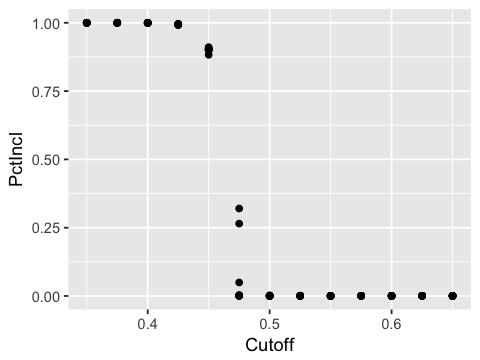

In [626]:
# Plot it
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df.list.permute,aes(x=Cutoff,y=PctIncl)) + geom_point()
p

In [627]:
df.no$Set = "Nothing"
df.list.permute$Set = "Error+Permnute"
df.list$Set = "Error"
df.full = rbind(df.no,df.list.permute,df.list)

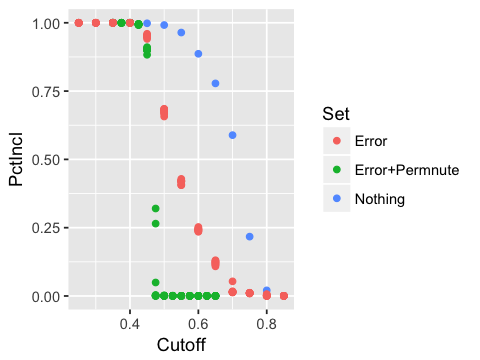

In [628]:
# Plot it
options(repr.plot.width=4, repr.plot.height=3)
p = ggplot(df.full,aes(x=Cutoff,y=PctIncl, color=Set)) + geom_point()
p

### The above code basically does what we want - calculates how large the largest cluster is for each of the rho cutoff values, with no alterations, adding random error, and adding random error plus rearranging the matrix randomly to result in no expected correlations. Thus, we can see where the rho cutoff values fall for all options. We should choose a cutoff that is higher than where the permuted one reaches ~1% of the OTUs being included in the largest cluster. We can then look at that cutoff in the actual (with added random error) data.  
#### For this dataset, that value is around 0.5. To be really confident in this, any chosen cutoff should be examined to make sure small variations in its value do not affect ecological conclusions  

####  "In practice, we suggest choosing a threshold slightly above the noise transition produced by the permutation test, and well below the point where the network breaks up into small, disconnected components."; "The threshold should be large enough to be above the noise transition (green line), but small enough that the network is not mostly disconnected."

Now we should be ready to use that cutoff to calculate the various parameters of the system.

###  Now, to test our confidence in the overall network developed, we will caculate a series of parameters about the network, and determine their null distributions.

#### First, we will use the derived network, based on the cutoff that we chose above.

In [46]:
#### Matrix with just noise added ####

df.reps=data.frame(m=c(),n=c(),k=c(),apl=c(),c=c())

rho = 0.5
# Calculated above
cutoff = 0.005
# Sum of least abundant taxa - leaves ~2160 taxa
delta = 1e-14
# Smaller than smallest difference between taxa

#Starting out running it 100 times
for (i in 1:100){

# Record iteration
Rep = i

# Losing low-abundance taxa
ps.mini = prune_taxa(taxa_sums(ps.merged.v) > cutoff, ps.merged.v)

# Making matrix of random values
b = delta/1000
E = replicate(dim(otu_table(ps.mini))[1], rnorm(dim(otu_table(ps.mini))[2]))
E = 2*b*E
E = -b + E

otu_table(ps.mini) = otu_table(as.matrix(otu_table(ps.mini))+abs(t(E)),taxa_are_rows=FALSE)
# Add the noise to the matrix

ps.dist.mini = cor(otu_table(ps.mini), use="everything", method="spearman") 
# Calculate spearman correlations

adjacency_matrix = as.matrix(ps.dist.mini)
# Turns Spearman into matrix
    
adjacency_matrix[abs(adjacency_matrix)<rho] = 0
adjacency_matrix[abs(adjacency_matrix)>rho] = 1
adjacency_matrix = adjacency_matrix[rowSums(adjacency_matrix)>0,]
# Set correlations below rho cutoff to 0, and above to 1
# Remove all taxa that have no correlations above the cutoff.
    
adjacency_matrix = graph.adjacency(adjacency_matrix, diag=FALSE, mode=c("undirected"), weighted=TRUE)
# Create adjacency matrix from correlation matrix

edge_list = get.edgelist(adjacency_matrix)
# Gets edge list from adjacency matrix
    
N = graph_from_data_frame(edge_list,directed=FALSE)
# Creates the network
    
m = ecount(N)
    # Number of edges
n = vcount(N)
    # Number of nodes
k = 2*m/n
    # Average degree
apl = mean_distance(N,directed=FALSE)
    # Average path length
c = transitivity(N)
    # Clustering coefficient of whole graph
    
# Apply the function to the range of values and turn it into a dataframe
df = data.frame(m,n,k,apl,c)
colnames(df) = colnames(df.reps)
df.reps=rbind(df.reps,df)
}
colnames(df.reps)=c("m","n","k","apl","c")

In [47]:
k.ave = mean(df.reps$k)
n.ave = mean(df.reps$n)
edges = k.ave * n.ave / 2
p = edges * 2 / (n.ave*n.ave)
# Probability that any pair of verticies is connected
# Thus we can generate a random matrix that preserved the degree of the network

In [48]:
df.ER=data.frame(Rep=c(),m=c(),n=c(),k=c(),apl=c(),c=c())

for (i in 1:100){
Rep=i
ER.thresh = matrix(runif(round(n.ave)*round(n.ave)),ncol=round(n.ave))
# Makes a random uniform matrix with the average number of nodes
ER.thresh[upper.tri(ER.thresh,diag=FALSE) & ER.thresh < (1-p)] = 0
ER.thresh[upper.tri(ER.thresh,diag=FALSE) & ER.thresh > (1-p)] = 1
# Set anything in the upper triangle that is below the threshold (1-p) to zero and anything above to 1
#ER.thresh[lower.tri(ER.thresh,diag=FALSE)] = t(ER.thresh[upper.tri(ER.thresh,diag=FALSE)])
ER.thresh[lower.tri(ER.thresh,diag=FALSE)] = 0
# Reflect the upper triangle to the lower triangle
diag(ER.thresh) = 0
# Set the diagonal to 0 (no self-connections)
# This is the ER random thresholded matrix

adjacency_matrix = graph.adjacency(ER.thresh, diag=FALSE, mode=c("undirected"), weighted=TRUE)
# Create adjacency matrix from correlation matrix

edge_list = get.edgelist(adjacency_matrix)
# Gets edge list from adjacency matrix
    
N = graph_from_data_frame(edge_list,directed=FALSE)
# Creates the network
    
m = ecount(N)
    # Number of edges
n = vcount(N)
    # Number of nodes
k = 2*m/n
    # Average degree
apl = mean_distance(N,directed=FALSE)
    # Average path length
c = transitivity(N)
    # Clustering coefficient of whole graph
    
# Apply the function to the range of values and turn it into a dataframe
df = data.frame(Rep,m,n,k,apl,c)
colnames(df) = colnames(df.ER)
df.ER=rbind(df.ER,df)
}
colnames(df.ER)=c("Rep","m","n","k","apl","c")

In [49]:
head(df.ER)
head(df.reps)

Rep,m,n,k,apl,c
1,9046,1590,11.37862,3.304391,0.006936991
2,9113,1590,11.46289,3.293381,0.007426310
3,9209,1590,11.58365,3.282354,0.008448404
4,9287,1590,11.68176,3.272726,0.007635559
5,9145,1590,11.50314,3.290447,0.007175802
6,9271,1590,11.66164,3.270678,0.006243266


m,n,k,apl,c
8814,1576,11.18528,4.168337,0.3138939
9575,1596,11.99875,4.203404,0.3332026
8970,1574,11.39771,4.107155,0.3300752
9032,1589,11.36816,4.233899,0.3239134
9222,1624,11.35714,4.119269,0.3226536
9148,1579,11.58708,4.207068,0.3239662


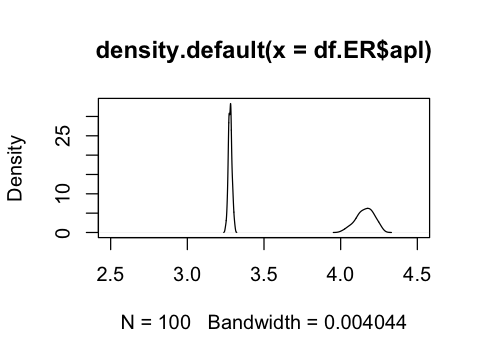

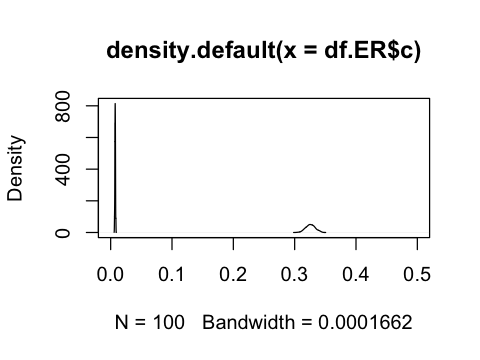

In [50]:
plot(density(df.ER$apl),xlim=c(2.5,4.5))
lines(density(df.reps$apl))

plot(density(df.ER$c),xlim=c(0,0.5))
lines(density(df.reps$c))

### Since our network statistics seem to lie well outside of the null distributions (more clustering and longer path length), it seems like there is a good chance that our network is not just representing random noise. The clustering coefficient (~0.32) is in a similar range as the Connor paper (0.38)

### Now we are ready to determine a consensus network. Connor et al. ran 2000 network simulations with added noise and using their permutationally-verified rho cutoff, and included edges that were present in 90% of their simulations.

In [644]:
#### Matrix with just noise added ####

cutoff = 0.005
# Sum of least abundant taxa - leaves ~2200 taxa

delta = 1e-14
# Smaller than smallest difference between taxa

rho = 0.5
# Determined using the permutations with noise above

EL = data.frame(Rep=c(),X1=c(),X2=c())

#Starting out running it 2000 times
for (i in 1:2000){

# Record iteration
Rep = i

# Setting code to run on smaller dataset - less-abundant taxa
#ps.mini = prune_taxa(taxa_sums(ps.merged.v) > cutoff, ps.merged.v)
ps.mini = prune_taxa((taxa_sums(ps.merged.v) > cutoff & taxa_sums(ps.merged.v) < 1 )| (taxa_sums(ps.merged.v) > (cutoff+2) & taxa_sums(ps.merged.v) < (1+2) ) | (taxa_sums(ps.merged.v) > (cutoff+4) & taxa_sums(ps.merged.v) < (1+4) ), ps.merged.v)
    
# Making matrix of random values
b = delta/1000
E = replicate(dim(otu_table(ps.mini))[1], rnorm(dim(otu_table(ps.mini))[2]))
E = 2*b*E
E = -b + E

otu_table(ps.mini) = otu_table(as.matrix(otu_table(ps.mini))+abs(t(E)),taxa_are_rows=FALSE)
# Add the noise to the matrix

ps.dist.mini = cor(otu_table(ps.mini), use="everything", method="spearman") 
# Calculate spearman correlations

adjacency_matrix = as.matrix(ps.dist.mini)
# Turns Spearman into matrix
    
adjacency_matrix[abs(adjacency_matrix)<rho] = 0
adjacency_matrix[abs(adjacency_matrix)>rho] = 1
adjacency_matrix = adjacency_matrix[rowSums(adjacency_matrix)>0,]
# Set correlations below rho cutoff to 0, and above to 1
# Remove all taxa that have no correlations above the cutoff.
    
adjacency_matrix = graph.adjacency(adjacency_matrix, diag=FALSE, mode=c("undirected"), weighted=TRUE)
# Create adjacency matrix from correlation matrix

edge_list = get.edgelist(adjacency_matrix)
# Gets edge list from adjacency matrix
    
edge_list = data.frame(Rep,edge_list)

EL = rbind(EL,edge_list)

}

In [645]:
EL$X3=""
EL$X3 = apply(EL,1,function(x) paste(sort(c(paste(x[2]),paste(x[3])))[1],sort(c(paste(x[2]),paste(x[3])))[2]))
# This is quite a bit (1-2x) faster than the paralellized mapply or the for loop.

In [646]:
head(EL)

Rep,X1,X2,X3
1,Bsq3,Bsq7,Bsq3 Bsq7
1,Bsq3,Bsq8,Bsq3 Bsq8
1,Bsq3,Bsq11,Bsq11 Bsq3
1,Bsq3,Bsq16,Bsq16 Bsq3
1,Bsq3,Bsq17,Bsq17 Bsq3
1,Bsq3,Bsq19,Bsq19 Bsq3


In [647]:
saveRDS(EL,"EL")
#EL=readRDS("EL")

In [685]:
# Finds how many instances of each pairing there are
Common = EL %>%
    group_by(X3)%>%
    summarize(n())

# We want those that are present 95% of the time
# For 2000 runs, that's n>=1900 or higher.
Consensus = Common[Common[,2]>=1900,]

dim(Consensus)
dim(Common)

[1] 1455    2

[1] 952022      2

In [686]:
# Divide the 90%-present paired responders back into two columns
# This is our consensus edge list
edge_list_consensus = separate(Consensus,1,into=c("X1","X2"),sep=" ")
edge_list_consensus = edge_list_consensus[,1:2]

In [687]:
edge_list = edge_list_consensus
# Setting edge list to the consensus value
# Then running through all previous graphing code

colnames(edge_list)=c("A","B")
edge_list=data.frame(edge_list)
edge_list$CorVal=""
edge_list$CorSign=""
head(edge_list)

A,B,CorVal,CorSign
Bsq100,Bsq15,,
Bsq100,Bsq21,,
Bsq100,Bsq223,,
Bsq100,Bsq27,,
Bsq100,Bsq55,,
Bsq100,Bsq61,,


In [688]:
# Want to add correlation values and colors for the consensus edges
# Because there are 700k edges, this takes a long time.

for (i in 1:dim(edge_list)[1]){
    CorVal = ps.dist.mini[which(rownames(ps.dist.mini)==data.frame(edge_list)$A[i]),
                 which(colnames(ps.dist.mini)==data.frame(edge_list)$B[i])]
    CorSign = ifelse(CorVal>0,"Positive","Negative")
    edge_list[i,3]=CorVal
    edge_list[i,4]=CorSign
    }
edge_list$EdgeColor[edge_list$CorSign=="Positive"] = "black"
edge_list$EdgeColor[edge_list$CorSign=="Negative"] = "red"
#edge_list$EdgeColor[edge_list$CorSign=="Positive"] = paste("0,0,128,0.25")
#edge_list$EdgeColor[edge_list$CorSign=="Negative"] = paste("128,0,0,0.25")
head(edge_list)

# Correlation values are relying on the last ps.dist.mini run
# Which would be different for each run, but we can assume,
# If it's consensus, and using the right cutoff,
# we should not be getting changing signs of correlation from one run to the next
# Could always use some average dist matrix for this step.

A,B,CorVal,CorSign,EdgeColor
Bsq100,Bsq15,0.616422569027611,Positive,black
Bsq100,Bsq21,0.566674669867947,Positive,black
Bsq100,Bsq223,0.671452581032413,Positive,black
Bsq100,Bsq27,0.551212484993998,Positive,black
Bsq100,Bsq55,0.683169267707083,Positive,black
Bsq100,Bsq61,0.677406962785114,Positive,black


In [689]:
#saveRDS(edge_list,"edge_list.OldAbund")
#saveRDS(igraph,"igraph.OldAbund")

In [690]:
#edge_list = readRDS("edge_list.OldAbund")

In [691]:
F.guilds = tax_table(ps.f.norm)
row.names(F.guilds) = gsub("sq","Fsq",row.names(F.guilds))
F.guilds = F.guilds[,c("Trophic.Mode","Guild","Growth.Morphology")]

In [692]:
igraph = graph_from_data_frame(edge_list,directed=FALSE)

In [693]:
### pH response ###

# Get the taxon info for nodes
node_list = V(igraph)$name

# Add fire-responsive data to the node list
#l2FC.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fcpH.df")
#l2FC.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fc.df")

m = l2FC.m%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC>1)%>%
    arrange(OTU)
m$OTU = gsub("sq","Bsq",m$OTU)

In [808]:
# Get the taxon info for nodes
node_list = data.frame(V(igraph)$name)

# Add the OTU ID column
colnames(node_list)[1] = "OTU"

# Add fire-responsive data to the node list
#l2FC.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fcpH.df")
l2FC.m = readRDS("../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fc.df")
l2FC.f =readRDS("CHTC/Dada2_Results_OA20_PEAR_Full/l2fcFull.df")

m = l2FC.m%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC>0)%>%
    arrange(OTU)
m$OTU = gsub("sq","Bsq",m$OTU)
m.fire.pos = levels(as.factor(m$OTU))

m = l2FC.m%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC<0)%>%
    arrange(OTU)
m$OTU = gsub("sq","Bsq",m$OTU)
m.fire.neg = levels(as.factor(m$OTU))

f = l2FC.f%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC>0)%>%
    arrange(OTU)
f$OTU = gsub("sq","Fsq",f$OTU)
f.fire.pos = levels(as.factor(f$OTU))

f = l2FC.f%>%
    group_by(logFC,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(logFC,MeanAbund,sigSeverity,OTU,Phylum,Class,Order,Family,Genus)%>%
    summarize()%>%
    filter(!is.na(logFC))%>%
    filter(sigSeverity==1)%>%
    filter(logFC<0)%>%
    arrange(OTU)
f$OTU = gsub("sq","Fsq",f$OTU)
f.fire.neg = levels(as.factor(f$OTU))

# Assigning fire response variables from l2FC calculation results
node_list$FireResponseColor = ""
node_list$FireResponseShape = ""
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    FireResponseColor = ifelse((OTU %in% f.fire.pos | OTU %in% m.fire.pos),"red",
                               ifelse((OTU %in% f.fire.neg | OTU %in% m.fire.neg),"blue","white"))
    FireResponseShape = ifelse((OTU %in% f.fire.pos | OTU %in% m.fire.pos),"square","circle")
    node_list$FireResponseColor[i] = FireResponseColor
    node_list$FireResponseShape[i] = FireResponseShape
}

In [822]:
node_list$Species = c()
node_list$Genus = c()
node_list$Family = c()
node_list$Order = c()
node_list$Class = c()
node_list$Phylum = c()
node_list$Kingdom = c()
node_list$Guild = c()
node_list$Trophic.Mode = c()
node_list$Growth.Morphology=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    Species = ifelse(OTU %in% row.names(tax_table(ps.merged.v)),paste(tax_table(ps.merged.v)[paste(OTU),"Species"]),"")
    Genus = ifelse(OTU %in% row.names(tax_table(ps.merged.v)),paste(tax_table(ps.merged.v)[paste(OTU),"Genus"]),"")
    Family = ifelse(OTU %in% row.names(tax_table(ps.merged.v)),paste(tax_table(ps.merged.v)[paste(OTU),"Family"]),"")
    Order = ifelse(OTU %in% row.names(tax_table(ps.merged.v)),paste(tax_table(ps.merged.v)[paste(OTU),"Order"]),"")
    Class = ifelse(OTU %in% row.names(tax_table(ps.merged.v)),paste(tax_table(ps.merged.v)[paste(OTU),"Class"]),"")
    Phylum = ifelse(OTU %in% row.names(tax_table(ps.merged.v)),paste(tax_table(ps.merged.v)[paste(OTU),"Phylum"]),"")
    Kingdom = ifelse(OTU %in% row.names(tax_table(ps.merged.v)),paste(tax_table(ps.merged.v)[paste(OTU),"Kingdom"]),"")
    Guild = ifelse(OTU %in% row.names(tax_table(F.guilds)),paste(tax_table(F.guilds)[paste(OTU),"Guild"]),"")
    Trophic.Mode = ifelse(OTU %in% row.names(tax_table(F.guilds)),paste(tax_table(F.guilds)[paste(OTU),"Trophic.Mode"]),"")
    GuildGrowth.Morphology= ifelse(OTU %in% row.names(tax_table(F.guilds)),paste(tax_table(F.guilds)[paste(OTU),"Growth.Morphology"]),"")
    node_list$Species[i] = Species
    node_list$Genus[i] = Genus
    node_list$Family[i] = Family
    node_list$Order[i] = Order
    node_list$Class[i] = Class
    node_list$Phylum[i] = Phylum
    node_list$Kingdom[i] = Kingdom
    node_list$Guild[i] = Guild
    node_list$Trophic.Mode[i] = Trophic.Mode
    node_list$Growth.Morphology[i] = GuildGrowth.Morphology
}

In [823]:
# Reporting the average abundance of each node (taxon)
node_list$MeanAbund = c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    MeanAbund = ifelse(OTU %in% m$OTU,m$MeanAbund[m$OTU==OTU],ifelse(OTU %in% f$OTU,f$MeanAbund[f$OTU==OTU],0.0001))
    node_list$MeanAbund[i] = MeanAbund
}


# Getting the finest-level taxonomic information we have
node_list$VertexSize = ifelse((as.numeric(node_list$MeanAbund)*500)>0.5,log(as.numeric(node_list$MeanAbund))*300,3)
node_list$VertexLabel = ifelse(!is.na(node_list$Genus) & node_list$Genus!="",paste(node_list$Genus),
                              ifelse(!is.na(node_list$Family) & node_list$Family!="",paste(node_list$Family),
                                    ifelse(!is.na(node_list$Order) & node_list$Order!="",paste(node_list$Order),
                                            ifelse(!is.na(node_list$Class) & node_list$Class!="",paste(node_list$Class),
                                                   ifelse(!is.na(node_list$Phylum) & node_list$Phylum!="",paste(node_list$Phylum),NA)))))


In [824]:
node_list$Plants = ifelse(node_list$Kingdom=="Plantae","green",
                          ifelse(node_list$Kingdom=="Bacteria","navy",
                                 ifelse(node_list$Kingdom=="Archaea","red",
                                     ifelse(node_list$Kingdom=="Fungi","yellow",
                                            ifelse(node_list$Kingdom=="","yellow","white")))))
node_list$Penn = ifelse(node_list$Family=="Micrococcaceae","navy","grey")
node_list$Phy = ifelse(node_list$Phylum=="Actinobacteria","orange",
                       ifelse(node_list$Phylum=="Gemmatimonadetes","blue",
                              ifelse(node_list$Phylum=="Acidobacteria","darkred",
                                     ifelse(node_list$Phylum=="Proteobacteria","darkgreen",
                                            ifelse(node_list$Phylum=="Bacteroidetes","black",
                                                   ifelse(node_list$Phylum=="Planctomycetes","pink",
                                                          ifelse(node_list$Phylum=="Firmicutes","red","white")))))))
node_list$Ord = ifelse(node_list$Order=="Eurotiales","navy","white")
node_list$Gen = ifelse(node_list$Genus=="Bradyrhizobium","navy","white")
node_list$Troph = ifelse(node_list$Trophic.Mode=="Saprotroph","navy","white")
node_list$GM = ifelse(node_list$Growth.Morphology=="Yeast","navy",
                      ifelse(node_list$Growth.Morphology=="Microfungus","blue",
                             ifelse(node_list$Growth.Morphology=="Agaricoid","red",
                                    ifelse(node_list$Growth.Morphology=="Boletoid","darkgreen","white"))))

In [825]:
# Assigning fire response variables from l2FC calculation results
node_list$pHResponse = ""

for (i in 1:dim(node_list)[2]){
    OTU = node_list$OTU[i]
    pHResponse = ifelse(OTU %in% m$OTU, m[m$OTU==OTU,]$logFC,0)
    node_list$pHResponse[i] = pHResponse
    }
head(node_list$pHResponse)

[1] "0"                 "0"                 "0"                
[4] "-1.10737370800887" "0"                 "-2.08473625817325"

In [826]:
# Could be interesting to colour by - e.g., relative abundance in wetlands
mdf = psmelt(ps.merged.v)

In [827]:
TotAbund = mdf %>%
    group_by(OTU)%>%
    summarize(MeanRelabund=log(mean(Abundance)))
node_list$TotAbund=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    TOT = ifelse(OTU %in% TotAbund$OTU, 
                ifelse(TotAbund[TotAbund$OTU==OTU,]$MeanRelabund!=(-Inf),TotAbund[TotAbund$OTU==OTU,]$MeanRelabund, min(TotAbund[TotAbund$OTU,]$MeanRelabund)))
    node_list$TotAbund[i] = TOT
    }

WAbund = mdf %>%
    filter(Veg_Comm==4)%>%
    group_by(OTU)%>%
    summarize(MeanRelabund=log(mean(Abundance)))
node_list$WAbund=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    WA = ifelse(OTU %in% WAbund$OTU, 
                ifelse(WAbund[WAbund$OTU==OTU,]$MeanRelabund!=(-Inf),WAbund[WAbund$OTU==OTU,]$MeanRelabund, min(WAbund[WAbund$OTU,]$MeanRelabund)))
    node_list$WAbund[i] = WA
    }

BSAbund = mdf %>%
    filter(Veg_Comm==1)%>%
    group_by(OTU)%>%
    summarize(MeanRelabund=log(mean(Abundance)))
node_list$BSAbund=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    BA = ifelse(OTU %in% BSAbund$OTU, 
                ifelse(BSAbund[BSAbund$OTU==OTU,]$MeanRelabund!=(-Inf),BSAbund[BSAbund$OTU==OTU,]$MeanRelabund, min(BSAbund[BSAbund$OTU,]$MeanRelabund)))
    node_list$BSAbund[i] = BA
    }

TWAbund = mdf %>%
    filter(Veg_Comm==5)%>%
    group_by(OTU)%>%
    summarize(MeanRelabund=log(mean(Abundance)))
node_list$TWAbund=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    TW = ifelse(OTU %in% TWAbund$OTU, 
                ifelse(TWAbund[TWAbund$OTU==OTU,]$MeanRelabund!=(-Inf),TWAbund[TWAbund$OTU==OTU,]$MeanRelabund, min(TWAbund[TWAbund$OTU,]$MeanRelabund)))
    node_list$BSAbund[i] = BA
    node_list$TWAbund[i] = TW
    }

JPAbund = mdf %>%
    filter(Veg_Comm==2)%>%
    group_by(OTU)%>%
    summarize(MeanRelabund=log(mean(Abundance)))
node_list$JPAbund=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    JP = ifelse(OTU %in% JPAbund$OTU, 
                ifelse(JPAbund[JPAbund$OTU==OTU,]$MeanRelabund!=(-Inf),JPAbund[JPAbund$OTU==OTU,]$MeanRelabund, min(JPAbund[JPAbund$OTU,]$MeanRelabund)))
    node_list$JPAbund[i] = JP
    }

MAbund = mdf %>%
    filter(Veg_Comm==3)%>%
    group_by(OTU)%>%
    summarize(MeanRelabund=log(mean(Abundance)))
node_list$MAbund=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    MA = ifelse(OTU %in% MAbund$OTU, 
                ifelse(MAbund[MAbund$OTU==OTU,]$MeanRelabund!=(-Inf),MAbund[MAbund$OTU==OTU,]$MeanRelabund, min(MAbund[MAbund$OTU,]$MeanRelabund)))
    node_list$MAbund[i] = MA
    }



In [828]:
df = mdf %>%
    #filter(Land_Class != "Wetland")%>%
    group_by(Site_ID,Veg_Comm,Phylum,Class,Order,Family,Genus,Species,OTU,CBI,RBR,Burn_Severity_Index)%>%
    summarize(TaxPresent = ifelse(sum(Abundance)>0,1,0))%>%
    filter(TaxPresent>0)%>%
    group_by(OTU)%>%
    summarize(MeanCBI=mean(CBI),MeanRBR=mean(RBR),MeanBSI=mean(Burn_Severity_Index))
head(df)

OTU,MeanCBI,MeanRBR,MeanBSI
Achillea_millefolia,1.670000,431.8200,3.441591
Acrocarpous_moss,1.665455,309.3732,3.265154
Amelanchier_alnifolia,1.880000,382.9797,4.125000
Anemone_canadensis,1.880000,382.9797,4.125000
Anemone_multifida,2.760000,405.6463,4.392500
Anemone_parviflora,1.710000,193.2305,2.910000


In [829]:
node_list$MeanCBI=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    x = ifelse(OTU %in% df$OTU, 
                ifelse(df[df$OTU==OTU,]$MeanCBI!=(-Inf),df[df$OTU==OTU,]$MeanCBI, min(df[df$OTU,]$MeanCBI)))
    node_list$MeanCBI[i] = x
    }

node_list$MeanBSI=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    x = ifelse(OTU %in% df$OTU, 
                ifelse(df[df$OTU==OTU,]$MeanBSI!=(-Inf),df[df$OTU==OTU,]$MeanBSI, min(df[df$OTU,]$MeanBSI)))
    node_list$MeanBSI[i] = x
    }

node_list$MeanRBR=c()
for (i in 1:dim(node_list)[1]){
    OTU = node_list$OTU[i]
    x = ifelse(OTU %in% df$OTU, 
                ifelse(df[df$OTU==OTU,]$MeanRBR!=(-Inf),df[df$OTU==OTU,]$MeanRBR, min(df[df$OTU,]$MeanRBR)))
    node_list$MeanRBR[i] = x
    }

head(node_list)

OTU,FireResponseColor,FireResponseShape,Species,Genus,Family,Order,Class,Phylum,Kingdom,⋯,pHResponse,TotAbund,WAbund,BSAbund,TWAbund,JPAbund,MAbund,MeanCBI,MeanBSI,MeanRBR
Bsq100,white,circle,NA,Mesorhizobium,Phyllobacteriaceae,Rhizobiales,Alphaproteobacteria,Proteobacteria,Bacteria,⋯,0,-6.592340,-8.222896,-8.121037,-6.018978,-6.519924,-6.672959,1.903158,3.590560,373.6563
Bsq1009,white,circle,NA,DA101_soil_group_ge,DA101_soil_group,Chthoniobacterales,Spartobacteria,Verrucomicrobia,Bacteria,⋯,0,-8.841789,-10.085500,-8.121037,-10.551065,-8.480978,-8.303104,1.696471,3.509225,349.7055
Bsq102,red,square,NA,Acidobacterium,Acidobacteriaceae_(Subgroup_1),Acidobacteriales,Acidobacteria,Acidobacteria,Bacteria,⋯,0,-6.547312,-7.075583,-8.121037,-7.746231,-6.459053,-6.017552,1.934615,3.587357,373.7422
Bsq104,blue,circle,NA,,Micromonosporaceae,Micromonosporales,Actinobacteria,Actinobacteria,Bacteria,⋯,-1.10737370800887,-6.861520,-7.337876,-8.121037,-6.674664,-7.777527,-6.633375,1.869583,3.422957,376.7776
Bsq105,red,square,NA,Acidobacterium,Acidobacteriaceae_(Subgroup_1),Acidobacteriales,Acidobacteria,Acidobacteria,Bacteria,⋯,0,-6.645905,NA,-8.121037,-5.906331,-7.095070,-6.318673,1.850000,3.422111,385.4920
Bsq106,blue,circle,NA,uncultured,Rhodobiaceae,Rhizobiales,Alphaproteobacteria,Proteobacteria,Bacteria,⋯,-2.08473625817325,-6.173023,-4.877707,-8.121037,-6.474825,-8.381715,-10.054905,1.649259,3.076437,293.7462


In [830]:
#saveRDS(edge_list,"edge_list")
#saveRDS(igraph,"igraph")
#saveRDS(node_list,"node_list")
#edge_list=readRDS("edge_list")
#node_list=readRDS("node_list")

In [862]:
length(levels(as.factor(node_list$Genus)))

[1] 109

In [906]:
set.seed(100)
# Creating consensus graph
igraph = graph_from_data_frame(edge_list,directed=FALSE)

# Setting abundance palette
#rbPal <- colorRampPalette(c('blue',"yellow"))
rbPal <- colorRampPalette(brewer.pal(9,"Spectral"))

# Assigning node (taxa) properties to the network
#V(igraph)$size=max((node_list$VertexSize^0.5)*6,3)
#V(igraph)$size=(node_list$VertexSize)
#V(igraph)$color = rbPal(20)[cut(as.numeric(node_list$MeanCBI),breaks = 20)]
#V(igraph)$color = rbPal(20)[cut(as.numeric(node_list$pHResponse),breaks = 20)]
#V(igraph)$color=node_list$FireResponseColor
#V(igraph)$color=node_list$Plants
#V(igraph)$color=node_list$Penn
#V(igraph)$color=node_list$Phy
V(igraph)$color=rbPal(17)[as.numeric(as.factor(node_list$Phylum))]
#V(igraph)$color=node_list$Gen
#V(igraph)$color=node_list$Ord
#V(igraph)$color=node_list$GM
V(igraph)$label=node_list$VertexLabel
#V(igraph)$color[!is.na(V(igraph)$label=="Salix")&V(igraph)$label=="Salix"] = "#00FF00"
#V(igraph)$label=paste(node_list$OTU)
#V(igraph)$label=node_list$Phylum
E(igraph)$color = edge_list$EdgeColor
E(igraph)$size = 4
E(igraph)$width = 4

In [898]:
graphjs(igraph,
        #layout=layout_on_sphere(igraph), 
        width=700,height=500,vertex.shape="circle",bg="white",fg="white",vertex.size=0.5,
       edge.alpha=0.75)
#network.graph = saveWidget(gjs, file="Network_graph_WB2015.html")

Warning message in graphjs(igraph, width = 700, height = 500, vertex.shape = "circle", :
“mulitple edge widths not yet supported”

HTML widgets cannot be represented in plain text (need html)

In [939]:
PhyCol = data.frame(V(igraph)$color,node_list$Phylum)
colnames(PhyCol) = c("Color","Phylum")
PhyCol = PhyCol %>%
    group_by(Color,Phylum)%>%
    summarize()%>%
    arrange(Phylum)
PhyCol$Color = ordered(PhyCol$Color,levels=PhyCol$Color)
PhyCol

Color,Phylum
#D53E4F,
#E45549,Acidobacteria
#F46D43,Actinobacteria
#F88D51,Armatimonadetes
#FDAE61,Ascomycota
#FDC775,Bacteria_unclassified(0)
#FEE08B,Bacteroidetes
#FEEFA4,Basidiomycota
#FFFFBF,Chloroflexi
#F2FAAB,Firmicutes


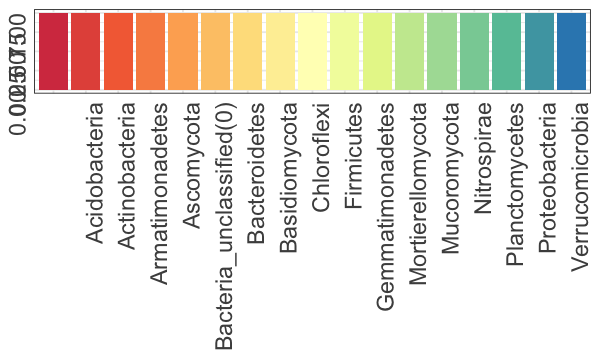

In [948]:
 options(repr.plot.width=5, repr.plot.height=3)
rhg_cols <- PhyCol$Color
 qplot(PhyCol$Phylum, fill = rhg_cols) +
   scale_fill_identity() + theme_bw() + 
    theme(axis.text = element_text(angle=90,hjust=1,size=14),
         axis.title  = element_blank(),
         axis.ticks = element_blank())

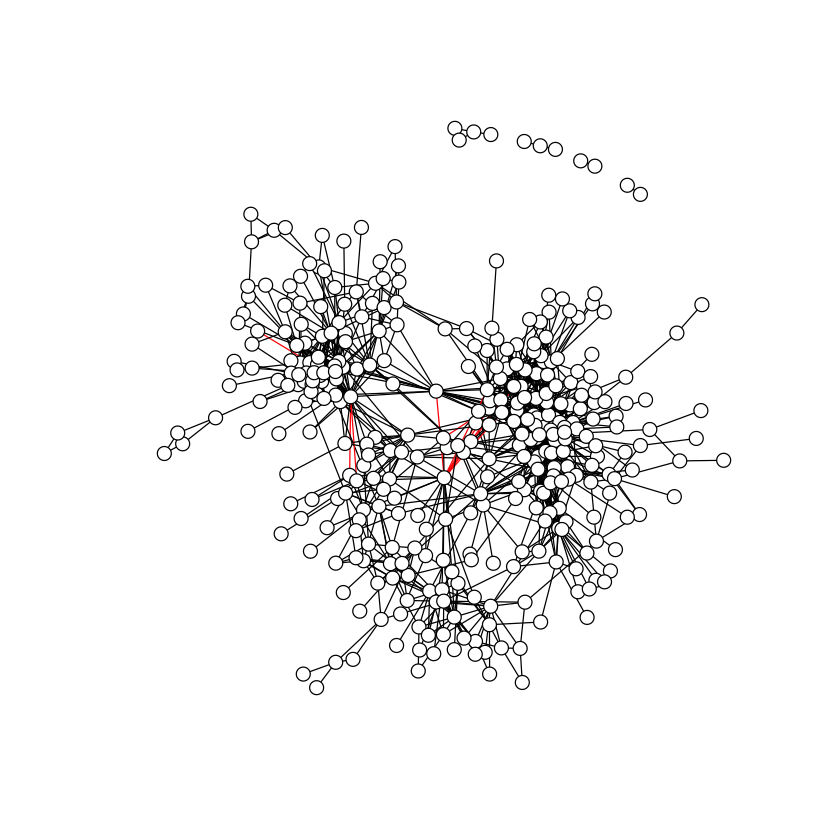

In [961]:
# Setting plot dimensions
set.seed(100)
options(repr.plot.width=7, repr.plot.height=7)

#L = layout_in_circle(igraph)
#L = layout_randomly(igraph)
#L = layout_on_sphere(igraph)
L = layout_with_fr(igraph)
#L = layout_with_kk(igraph)

# Graphing consensus network
p = plot.igraph(igraph,
            vertex.label=NA,
            vertex.size=c(5),
                vertex.alpha=c(0.5),
            #vertex.label.cex=c(0.5),
            vertex.color=c("white"),
            edge.width=c(1),
            layout=L#, mark.groups=C
            )

ERROR: Error in symbols(x = coords[, 1], y = coords[, 2], bg = vertex.color, : invalid symbol parameter


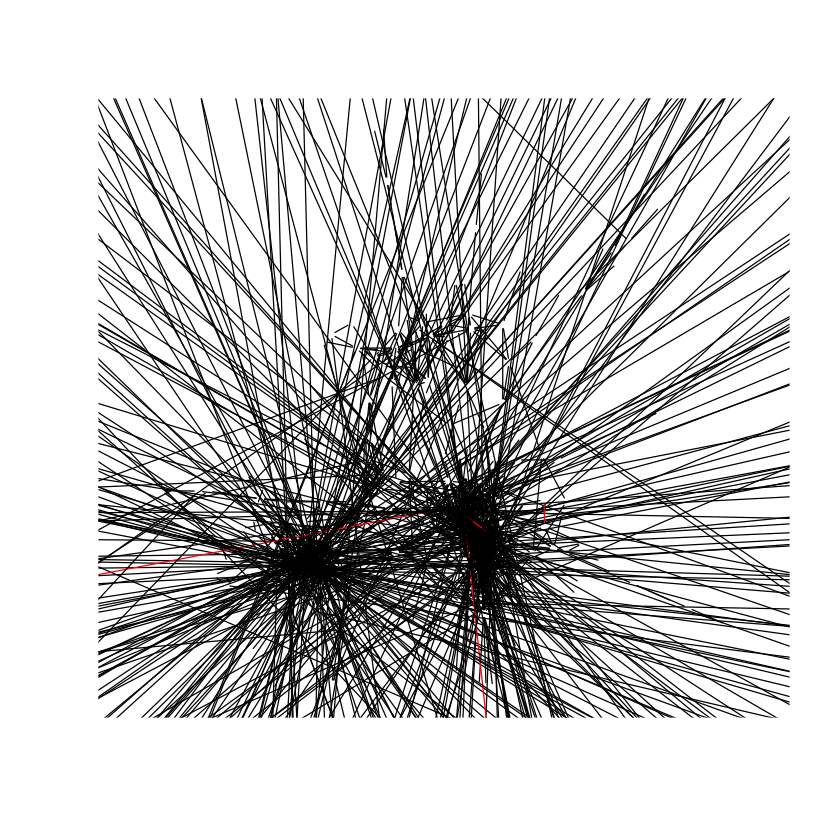

In [229]:
igraph.sm=decompose.graph(igraph)[[1]]

# Get rid of anything not kept in the adjacency matrix
nodes.remaining = V(igraph.sm)$name
node_list.sm = node_list[row.names(node_list) %in% nodes.remaining,]

p = plot.igraph(igraph.sm, 
            #vertex.label.cex=c(0.75),
            #vertex.label.color=c("black"),
            #vertex.label.dist=c(0.75),
            edge.color=edge_list$EdgeColor,
            edge.width=1
           )
#p